In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from spectral import *
import numpy as np
import scipy.spatial.distance as distance
import pylab
import spectral.io.envi as envi
import random
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import timeit
import math

In [4]:
from autoclustering import find_maxdist_clusters
from hiersubclustering import subdivide_by_modules
from visual_utils import show_classes, show_histogram, show_centers
from math_utils import cluster_histogram, normalized

In [5]:
img = aviris.open('f970619t01p02_r02_sc04.a.rfl', 'f970619t01p02_r02.a.spc')

	Data Source:   '/home/marko/HSI/f970619t01p02r02c/f970619t01p02_r02_sc04.a.rfl'
	# Rows:            512
	# Samples:         614
	# Bands:           224
	Interleave:        BIP
	Quantization:  16 bits
	Data format:     int16
float64


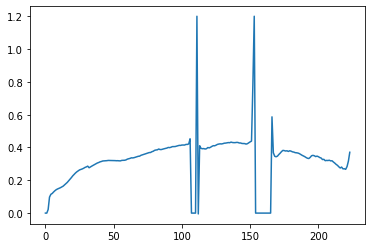

In [6]:
print(img)
print(img[380, 496].dtype)
pylab.plot(img[380, 496])

In [7]:
data = img[:,:,:]
data[data < 0] = 0
data[:, :, 106:115] = 0
data[:, :, 148:169] = 0

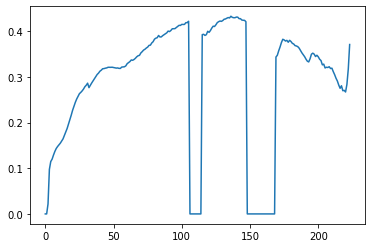

In [8]:
pylab.plot(data[380, 496])

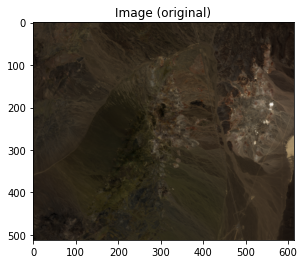

In [9]:
view = imshow(data, (29, 20, 12), title="Image (original)")

In [10]:
wavelengths_original = np.array(img.bands.centers)
wavelengths_sorted = np.sort(wavelengths_original)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, img.bands.bandwidths)
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000

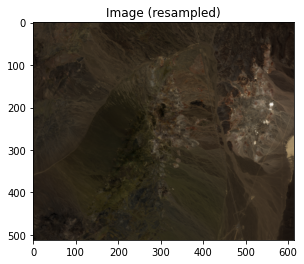

In [11]:
view = imshow(data, (29, 20, 12), title="Image (resampled)")

In [12]:
subdata = data[0:50, 0:50]

Computed continuum of the all the spectra in 0.003136771000072258


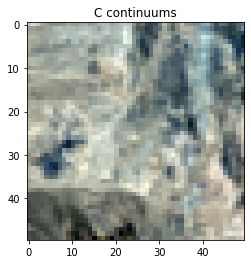

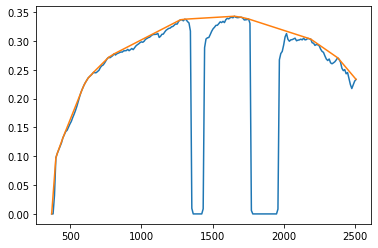

In [13]:
from ccontinuum import continuum
sc_continuums = np.empty((subdata.shape[0] * subdata.shape[1], subdata.shape[2]))

starttime = timeit.default_timer()
continuum(subdata.reshape(sc_continuums.shape), sc_continuums, wavelengths)
sc_continuums = sc_continuums.reshape(subdata.shape)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

imshow(sc_continuums, (29, 20, 12), title="C continuums")
pylab.figure()
pylab.plot(wavelengths, data[4, 7])
pylab.plot(wavelengths, sc_continuums[4, 7])

Computed continuum of the all the spectra in 0.012945510000008653
Result diff from C  1.0886992696246267e-11


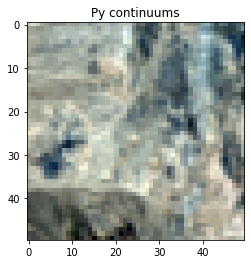

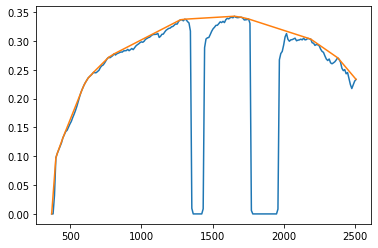

In [14]:
from pycontinuum import continuum
py_continuums = np.empty_like(subdata)

starttime = timeit.default_timer()
continuum(subdata, wavelengths, out=py_continuums)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

print('Result diff from C ', np.linalg.norm((py_continuums - sc_continuums).reshape(-1), 1))

imshow(py_continuums, (29, 20, 12), title="Py continuums")
pylab.figure()
pylab.plot(wavelengths, subdata[4, 7])
pylab.plot(wavelengths, py_continuums[4, 7])

[0.5    1.1    1.8    2.     1.8625 0.9    0.4   ]


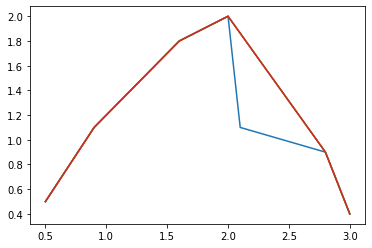

In [17]:
from pycontinuum import find_continuum_points_recursive, find_continuum_points_iterative
import ccontinuum
# wls = wavelengths
#spectrum = img[163, 145]
# spectrum = data[134, 257]
# wls = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float)
# spectrum = np.array([1, 2, 2.5, 1.6, 0.75, 1.5, 2.2, 2.9, 1.8])
#ls = np.array([1, 2, 3, 4, 5], dtype=float)
#spectrum = np.array([1, 1.2, 2.5, 1.0, 0.75])
#wls = wavelengths #[0:32]
#spectrum = data[4, 16]
# wls =      np.array([0.30, 1.00, 1.80, 3.00, 4.50, 5.20, 6.45, 7.00, 7.10, 8.00, 8.10, 9.00, 9.30, 10.20, 10.50, 10.6], dtype=float)
# spectrum = np.array([0.60, 1.00, 2.45, 3.10, 3.25, 4.15, 4.35, 4.10, 3.10, 2.70, 2.00, 2.85, 3.75, 3.00, 2.00, 0.90], dtype=float)
#spectrum = data[134, 257][:5]
#wls = np.arange(len(wavelengths[:5]), dtype=float)
#wls = wavelengths[:5]
# wls = np.array([0.5, 1.0, 1.7, 2.0, 3.0, 3.5])
# spectrum = np.array([0.5, 1.1, 1.5, 2.4, 1.9, 1.0])
spectrum = np.array([0.5, 1.1, 1.8, 2.0, 1.1, 0.9, 0.4])
wls = np.array([0.5, 0.9, 1.6, 2.0, 2.1, 2.8, 3.0])

indices = np.empty_like(spectrum, dtype=int)
segment_range = wls[-1] - wls[0]
x, y = find_continuum_points_recursive(spectrum, wls, indices)
pylab.plot(wls, spectrum)
pylab.plot(x, y)
x2, y2 = find_continuum_points_iterative(spectrum, wls, indices)
pylab.plot(x2, y2)

ot = np.empty_like(spectrum)
ccontinuum.continuum(spectrum, ot, wls)
pylab.plot(wls, ot)

print(ot)

(array([0.6       , 1.46333333, 2.45      , 3.1       , 3.81590909,
       4.15      , 4.35      , 4.18024691, 4.14938272, 3.87160494,
       3.86234568, 3.85      , 3.84634146, 3.73658537, 3.7       ,
       3.        , 2.        , 0.9       ]),)


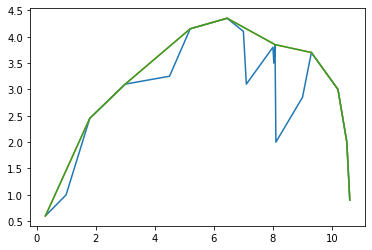

In [18]:
from spectral.algorithms.continuum import continuum_points, spectral_continuum, remove_continuum
# wls = wavelengths
#spectrum = img[163, 145]
# spectrum = data[134, 257]
# wls = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=float)
# spectrum = np.array([1, 2, 2.5, 1.6, 0.75, 1.5, 2.2, 2.9, 1.8])
#ls = np.array([1, 2, 3, 4, 5], dtype=float)
#spectrum = np.array([1, 1.2, 2.5, 1.0, 0.75])
#wls = wavelengths #[0:32]
#spectrum = data[4, 16]
wls =      np.array([0.30, 1.00, 1.80, 3.00, 4.50, 5.20, 6.45, 7.00,
                             7.10, 8.00, 8.03, 8.07, 8.10, 9.00, 9.30, 10.20, 10.50, 10.6], dtype=float)
# wls = np.cumsum(np.concatenate((np.array([0.3]), (wls[1:] - wls[:-1])[::-1])))
spectrum = np.array([0.60, 1.00, 2.45, 3.10, 3.25, 4.15, 4.35, 4.10, 3.10, 3.80, 3.50, 3.85, 2.00, 2.85, 3.70, 3.00, 2.00, 0.90], dtype=float)
# spectrum = spectrum[::-1]
#spectrum = data[134, 257][:5]
#wls = np.arange(len(wavelengths[:5]), dtype=float)
#wls = wavelengths[:5]
# wls = np.array([0.5, 1.0, 1.7, 2.0, 3.0, 3.5])
# spectrum = np.array([0.5, 1.1, 1.5, 2.4, 1.9, 1.0])
#spectrum = np.array([0.5, 1.1, 1.8, 2.0, 1.1, 0.9, 0.4])
#wls = np.array([0.5, 0.9, 1.6, 2.0, 2.1, 2.8, 3.0])

indices = np.empty_like(spectrum, dtype=int)
segment_range = wls[-1] - wls[0]
x, y = continuum_points(spectrum, wls, 'segmented')
pylab.plot(wls, spectrum)
pylab.plot(x, y)

ot = np.empty_like(spectrum)
spectral_continuum(spectrum, wls, 'segmented', ot)
pylab.plot(wls, ot)

print((ot,))

Computed continuum of the all the spectra in 0.23825848699993912


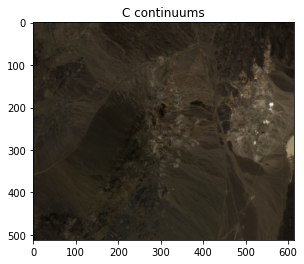

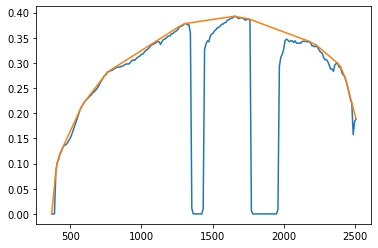

In [19]:
from ccontinuum import continuum
c_continuums = np.empty_like(data)

starttime = timeit.default_timer()
continuum(data, c_continuums, wavelengths)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

imshow(c_continuums, (29, 20, 12), title="C continuums")
pylab.figure()
pylab.plot(wavelengths, data[134, 257])
pylab.plot(wavelengths, c_continuums[134, 257])

Computed continuum of the all the spectra in 0.8037563620000583
Result diff from C  5.134781488891349e-15


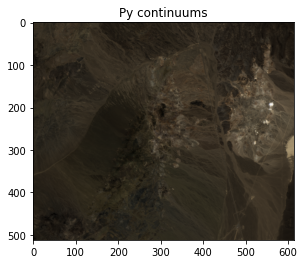

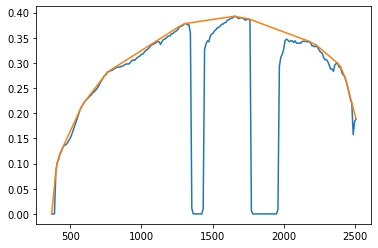

In [20]:
from pycontinuum import continuum
py_continuums = np.empty_like(data)

starttime = timeit.default_timer()
continuum(data, wavelengths, out=py_continuums)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

print('Result diff from C ', np.linalg.norm((py_continuums - c_continuums).reshape(-1), float('inf')))

imshow(py_continuums, (29, 20, 12), title="Py continuums")
pylab.figure()
pylab.plot(wavelengths, data[134, 257])
pylab.plot(wavelengths, py_continuums[134, 257])

ImageView object:
  Display bands       :  [0, 110, 219]
  Interpolation       :  <default>
  RGB data limits     :
    R: [2632.0, 4536.0]
    G: [1017.0, 1159.0]
    B: [980.0, 1034.0]

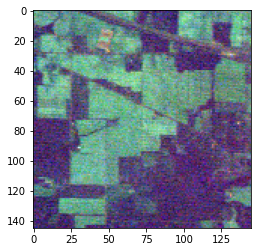

In [21]:
test_img = open_image('92AV3C.lan')
imshow(test_img)

220 220 None 220 Wavelength nm


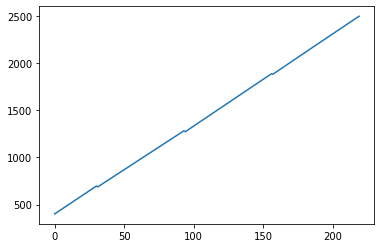

In [22]:
test_bands = aviris.read_aviris_bands('92AV3C.spc')
print(
    len(test_bands.centers),
    len(test_bands.bandwidths),
    test_bands.centers_stdevs,
    len(test_bands.bandwidth_stdevs),
    test_bands.band_quantity,
    test_bands.band_unit
)
pylab.plot(test_bands.centers)

[676.570007 686.530029 696.5      686.909973 696.549988 706.190002]


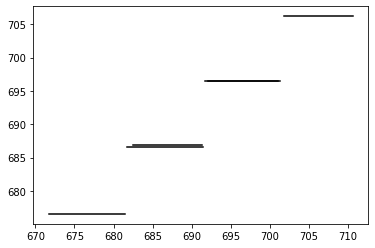

In [23]:
local_wl_centers = np.array(test_bands.centers[28:34])
local_bandwidths = np.array(test_bands.bandwidths[28:34])
band_starts = local_wl_centers - local_bandwidths / 2
band_ends = local_wl_centers + local_bandwidths / 2

print(local_wl_centers)

pylab.figure()
for (c, s, e) in zip(local_wl_centers, band_starts, band_ends):
    pylab.plot([s, e], [c, c], color='black')

pylab.show()

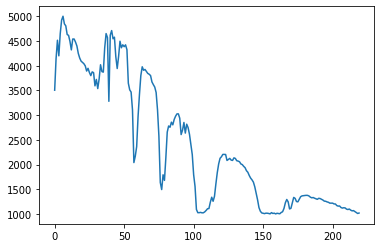

In [24]:
pylab.plot(test_img[20, 20])

(220,) (220,) 220
(array([ 400.019989,  409.820007,  419.619995,  449.070007,  458.899994,
        783.27002 ,  802.530029,  841.039978,  860.280029,  879.530029,
        994.880005, 1014.090027, 1052.48999 , 1244.26001 , 1273.      ,
       1282.959961, 1541.589966, 1561.439941, 1620.97998 , 1630.900024,
       2122.780029, 2132.72998 , 2172.5     , 2212.219971, 2222.149902,
       2311.350098, 2331.139893, 2360.810059, 2390.459961, 2400.330078,
       2429.949951, 2459.540039, 2498.959961]), array([3505, 4141, 4516, 4924, 5002, 4712, 4578, 4496, 4424, 4423, 3979,
       3925, 3801, 3026, 2852, 2817, 2206, 2204, 2136, 2124, 1377, 1376,
       1333, 1317, 1312, 1219, 1202, 1162, 1126, 1122, 1100, 1068, 1019],
      dtype=int16))


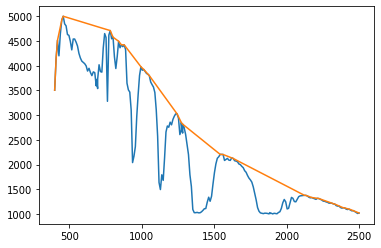

In [25]:
from spectral.algorithms.continuum import continuum_points, remove_continuum, spectral_continuum
from visual_utils import draw_common_2cols_graphs
test_spectrum = test_img[20, 20]
bands_sorted = np.sort(test_bands.centers)
cnt = spectral_continuum(test_spectrum, bands_sorted, 'segmented')
cr = np.empty_like(test_spectrum, dtype=np.float64)
remove_continuum(test_spectrum, bands_sorted, 'segmented', out=cr)
print(cnt.shape, cr.shape, len(bands_sorted))

pylab.plot(bands_sorted, test_spectrum)
pylab.plot(bands_sorted, cnt)

print(continuum_points(test_spectrum, bands_sorted, 'segmented'))


(array([1.        , 0.6833713 , 1.        , 1.        , 0.85169744,
       1.        , 1.        , 0.98680124, 0.75254503, 1.        ,
       0.52684904, 0.75766871, 1.        , 1.        , 1.        ,
       1.        ]),)


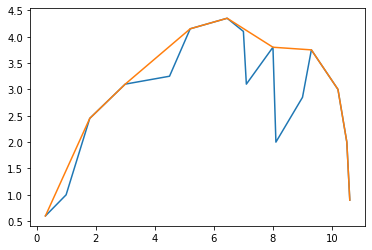

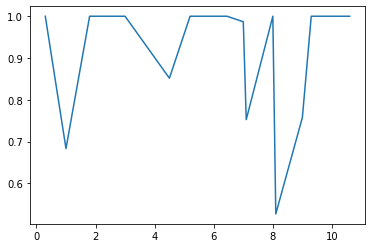

In [26]:
bands = np.array([0.30, 1.00, 1.80, 3.00, 4.50, 5.20, 6.45, 7.00, 7.10, 8.00,
                  8.10, 9.00, 9.30, 10.20, 10.50, 10.6])
spectrum = np.array([0.60, 1.00, 2.45, 3.10, 3.25, 4.15, 4.35, 4.10, 3.10,
                     3.80, 2.00, 2.85, 3.75, 3.00, 2.00, 0.90])
cr = remove_continuum(spectrum, bands, mode='segmented')
pylab.plot(bands, spectrum)
pylab.plot(bands, spectral_continuum(spectrum, bands, mode='segmented'))
pylab.figure()
pylab.plot(bands, cr)
print((cr,))

Computed continuum of the all the spectra in 1.1676462450000145
Result diff from C  0.05279380256108607


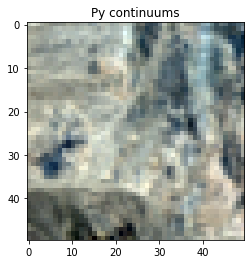

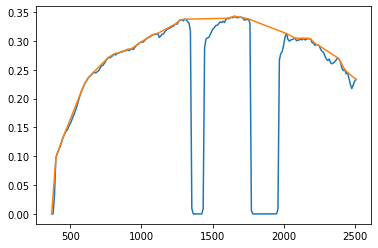

In [27]:
from spectral.algorithms.continuum import spectral_continuum
py_continuums = np.empty_like(subdata)

starttime = timeit.default_timer()
spectral_continuum(subdata, wavelengths, mode = 'segmented', out=py_continuums)
endtime = timeit.default_timer()
print('Computed continuum of the all the spectra in {}'.format(endtime - starttime))

print('Result diff from C ', np.linalg.norm((py_continuums - sc_continuums).reshape(-1), float('inf')))

imshow(py_continuums, (29, 20, 12), title="Py continuums")
pylab.figure()
pylab.plot(wavelengths, subdata[4, 7])
pylab.plot(wavelengths, py_continuums[4, 7])

In [28]:
from spectral.algorithms.continuum import _segment_concave_region

In [29]:
%load_ext line_profiler

In [30]:
%lprun -f _segment_concave_region spectral_continuum(subdata, wavelengths, 'segmented', out=py_continuums)

Timer unit: 1e-06 s

Total time: 1.28866 s
File: /home/marko/hyperspectralplayground/build/lib.linux-x86_64-3.6/spectral/algorithms/continuum.py
Function: _segment_concave_region at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def _segment_concave_region(spectrum, bands, indices, ind_fill, ibegin, iend):
    35                                               # Here we don't search for local maxima w.r.t. line that connects ends of this region.
    36                                               # That is behavior of the hsdar. It also makes more sense in the context of
    37                                               # hyperspectral image analysis. We are already not convex, and we can't
    38                                               # include all points that make result quasi-convex, since there will be too
    39                                               # many of them, often right one after anot

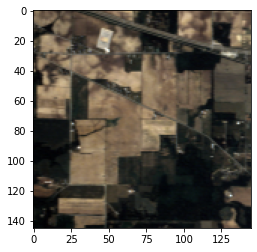

In [80]:
img = open_image('92AV3C.lan').load()
v = imshow(img, (29, 20, 12))

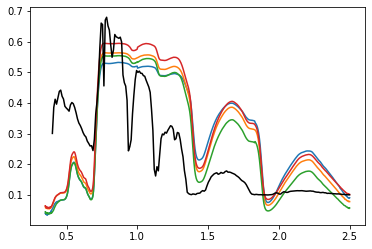

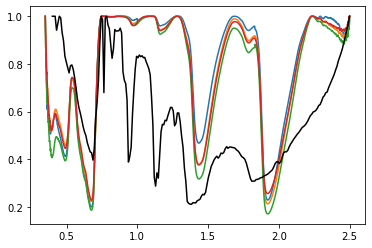

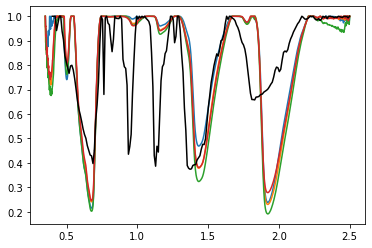

In [96]:
import spectral as spy
import matplotlib.pyplot as plt

# Read pixel signature.
img = open_image('92AV3C.lan')
vegetation = img[100, 60]

# Read bands.
bands = aviris.read_aviris_bands('92AV3C.spc')
# We need bands to be sorted.
bands_sorted = np.sort(bands.centers)
# Adjust signature to sorted bands.
resampler = BandResampler(bands.centers, bands_sorted, bands.bandwidths)
# Aviris data is multiplied by 10000.
vegetation = resampler(vegetation) / 10000
# Use micrometers like spectral library does.
bands_um = bands_sorted / 1000

# Open spectral library database.
db = EcostressDatabase('ecostress.db')
# Read some IDs of grass, where band range is close to that of AVIRIS.
grass_ids = [id for id, in db.query(f'SELECT SampleID FROM Spectra WHERE SampleID IN'
                                    f' (SELECT SampleID FROM Samples WHERE Name LIKE "%grass%" OR Description LIKE "%grass%" OR Class LIKE "%grass%" limit 10)'
                                    f' AND MinWavelength >= 0.35 AND  MinWavelength <= 0.38 AND MaxWavelength >= 2.4 AND MaxWavelength <= 2.6')]
# Get signatures for those IDs.
ecograss_spectra = [db.get_signature(id) for id in grass_ids]
# Transform siguratures into 2-tuple of ndarray for convenience, and also devide by 100 as library holds percentages.
ecograss_spectra = [(np.array(s.x), np.array(s.y) / 100) for s in ecograss_spectra]

# Plot grass for library.
plt.figure()
for x, y in ecograss_spectra:
    plt.plot(x, y)
# Compare plot with vegetation from the image.
plt.plot(bands_um, vegetation, color='black')

# Remove continuum.
ecograss_continuum_removed = [(x, spy.continuum.remove_continuum(y, x)) for x, y in ecograss_spectra]

# And, compare plots again.
plt.figure()
for x, y in ecograss_continuum_removed:
    plt.plot(x, y)
plt.plot(bands_um, spy.continuum.remove_continuum(vegetation, bands_um), color='black')

# Remove segmented upper hull.
ecograss_continuum_removed = [(x, spy.continuum.remove_continuum(y, x, mode='segmented')) for x, y in ecograss_spectra]

# And, compare plots again.
plt.figure()
for x, y in ecograss_continuum_removed:
    plt.plot(x, y)
plt.plot(bands_um, spy.continuum.remove_continuum(vegetation, bands_um, mode='segmented'), color='black')

In [72]:
print(grass_ids)

[716, 808, 830, 1322]


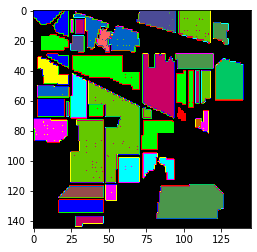

In [33]:
gt = open_image('92AV3GT.GIS').read_band(0)
v = imshow(classes=gt)

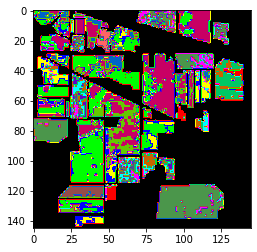

In [34]:
classes = create_training_classes(img, gt, True)
means = np.zeros((len(classes), img.shape[2]), float)
for (i, c) in enumerate(classes):
    means[i] = c.stats.mean

angles = spectral_angles(img, means)
clmap = np.argmin(angles, 2)
clmap_corrected = clmap + 1
v = imshow(classes=(clmap_corrected * (gt != 0)))

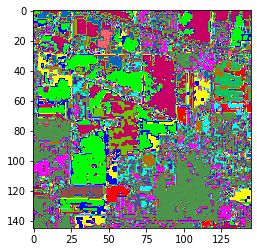

In [35]:
v = imshow(classes=clmap_corrected)

Missclassfied 5901


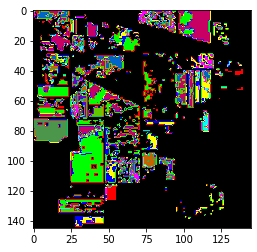

In [36]:
errors = (clmap_corrected * (gt != 0)) * (clmap_corrected != gt)
print('Missclassfied {}'.format(np.sum(errors != 0)))
v = imshow(classes=(errors))

In [37]:
bands = test_bands

False


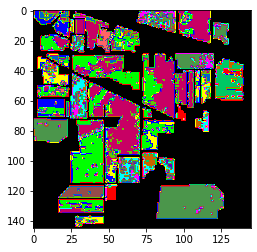

In [38]:
data = img.load()
sorted_band_centers = np.sort(bands.centers)
print(np.array_equal(np.array(bands.centers), sorted_band_centers))
data_cr = remove_continuum(data, np.array(bands.centers), mode='convex')
means_cr = remove_continuum(means, np.array(bands.centers), mode='convex')
angles = spectral_angles(data_cr, means_cr)
clmap = np.argmin(angles, 2)
clmap_corrected = clmap + 1
v = imshow(classes=(clmap_corrected * (gt != 0)))

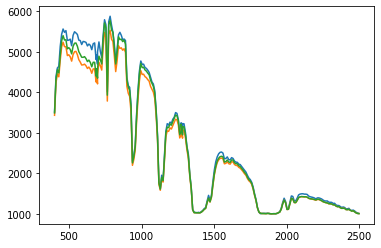

In [39]:
pylab.plot(sorted_band_centers, data[5, 105])
pylab.plot(sorted_band_centers, means[10])
pylab.plot(sorted_band_centers, means[1])

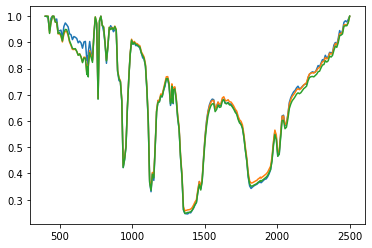

In [40]:
pylab.plot(sorted_band_centers, data_cr[5, 105])
pylab.plot(sorted_band_centers, means_cr[10])
pylab.plot(sorted_band_centers, means_cr[1])

In [41]:
print(gt[5, 105])
print(clmap_corrected[5, 105])

11
2


Missclassified 6046


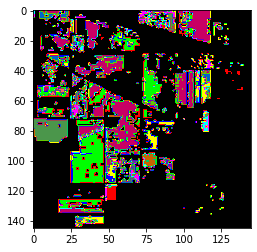

In [42]:
errors = (clmap_corrected * (gt != 0)) * (clmap_corrected != gt)
print('Missclassified {}'.format(np.sum(errors != 0)))
v = imshow(classes=(errors))

Missclassified 6046


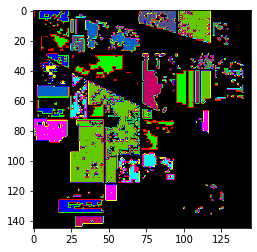

In [43]:
corrects = gt * (clmap_corrected != gt)
print('Missclassified {}'.format(np.sum(corrects != 0)))
v = imshow(classes=(corrects))

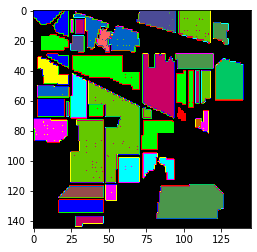

In [44]:
v = imshow(classes=gt)

In [45]:
cprad_img = aviris.open('f960705t01p02_r02c_img', 'f960705t01p02_r02.spc')

ImageView object:
  Display bands       :  [29, 18, 8]
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.0366, 0.6522]
    G: [0.0796, 0.7361]
    B: [0.1237, 0.68]

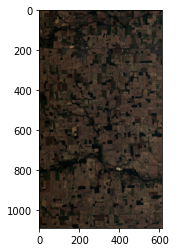

In [46]:
imshow(cprad_img)

In [47]:
data = cprad_img.load()
wavelengths_original = np.array(cprad_img.bands.centers)

In [48]:
wavelengths_sorted = np.sort(wavelengths_original)
resampler = BandResampler(wavelengths_original, wavelengths_sorted, cprad_img.bands.bandwidths)
img_width = data.shape[0]
img_height = data.shape[1]
img_depth = data.shape[2]
data = np.dot(data.reshape(img_width*img_height, img_depth), resampler.matrix.T)
data = data.reshape(img_width, img_height, img_depth)
wavelengths = wavelengths_sorted
wavelengths_um = wavelengths / 1000

In [49]:
signature = data[190, 100]
imax = np.argmax(signature)

In [50]:
from pycontinuum import continuum
cnt = continuum(signature, wavelengths)

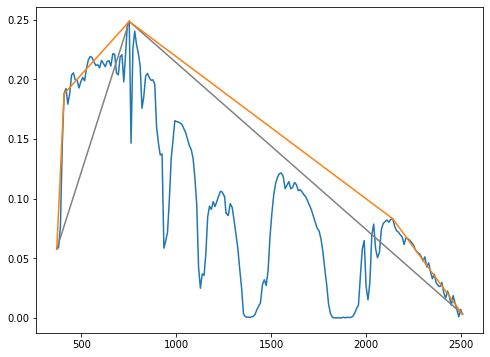

In [51]:
fig = pylab.figure()
fig.set_size_inches(8, 6)
pylab.plot(wavelengths, signature, color='tab:blue')
pylab.plot([wavelengths[0], wavelengths[imax]], [signature[0], signature[imax]], color='gray')
pylab.plot([wavelengths[0], wavelengths[4]], [signature[0], signature[4]], color='tab:orange')
pylab.plot([wavelengths[4], wavelengths[imax]], [signature[4], signature[imax]], color='tab:orange')
pylab.plot([wavelengths[imax], wavelengths[-1]], [signature[imax], signature[-1]], color='gray')
pylab.plot([wavelengths[imax], wavelengths[186]], [signature[imax], signature[186]], color='tab:orange')
pylab.plot([wavelengths[186], wavelengths[-1]], [signature[186], signature[-1]], color='tab:orange')

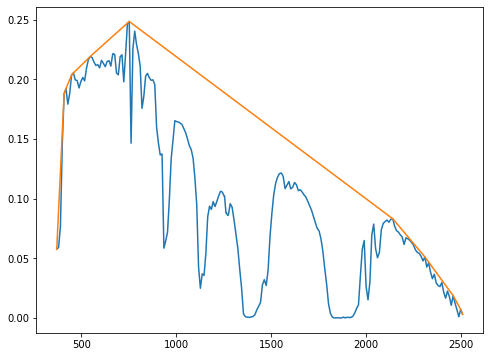

In [52]:
from spectral.algorithms.continuum import spectral_continuum
fig = pylab.figure()
fig.set_size_inches(8, 6)
pylab.plot(wavelengths, signature)
pylab.plot(wavelengths, spectral_continuum(signature, wavelengths))